Fitting with user-defined functions
===

There are numerous ways to express functions in ROOT (https://root.cern.ch/doc/master/classTF1.html) in this example we'll explore a general method of defining fit functions.  Again we will use the ROOT fitting framework for the next couple of exercies to illustrate some general featues of the non-linear fitting problems.  Some of the examples we see may be replicated in scipy.optimize, but not neceassarily all of them.

ROOT classes used here:
* [TF1](https://root.cern.ch/doc/master/classTF1.html): 1D function
* [TH1F](https://root.cern.ch/doc/master/classTH1.html): 1D histogram (the content of each bin is described by a float)

In [2]:
!pip install ROOT

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 MB 5.3 MB/s eta 0:00:00


In [3]:
import ROOT as r
%jsroot off

First we define a function and store it in a TF1 object.  In this example we will use Pythonic interfaces, next time we'll see how the same patterns can be used in C++.

In [4]:
from math import pow, exp

# A function producing two peaks on top of an exponentialy
# falling background.  Depends on several parameters.
# Generic interface for fcn of n input-values and m parameters
# Functions with this interface may be used to construct a "TFunction" or TF1
# vx is the independent value(s): array like
# p is the parameter value(s): array like

def myfunction(vx, par):
    x=vx[0]
    # background model
    bkgScale=par[0]
    alpha=par[1]
    beta=par[2]
    background = pow(x/beta,-1.0*alpha)
    # first peak, Gaussian model
    A1=par[3]
    mu1=par[4]
    sig1=par[5]
    peak1=A1*exp(-0.5*(x-mu1)*(x-mu1)/sig1/sig1)
    # second peak, Gaussian model
    A2=par[6]
    mu2=par[7]
    sig2=par[8]
    peak2=A2*exp(-0.5*(x-mu2)*(x-mu2)/sig2/sig2)
    return bkgScale*background+peak1+peak2

xrange=(300,1000)
f1 = r.TF1("f1",myfunction,xrange[0],xrange[1],9)  # xrange 300<=x<=1000, there are 9 parameters in this function
f1.SetNpx(500)  # use large number of points in drawing function to resolve small details better
f1.SetParameters(1e9,4.7,40,5000,490,2,1200,800,25)  # define the parameters
f1.SetParNames("BkgScale","alpha","beta","A1","mu1","sig1","A2","mu2","sig2")  # optional, but nice

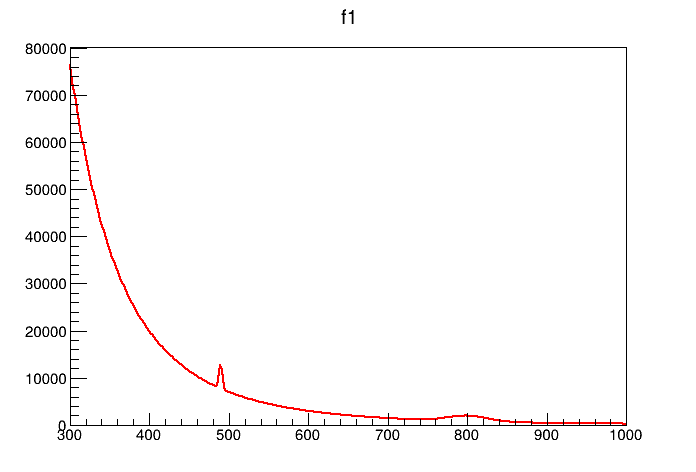

In [5]:
tc=r.TCanvas()
f1.Draw()
tc.Draw()

Generate random data according to this distribution

In [ ]:
entries=100000
ranHist1 = r.TH1F("ranHist1", "Random Histogram for my PDF;x;entries",500,xrange[0],xrange[1]);
ranHist1.FillRandom("f1",entries)

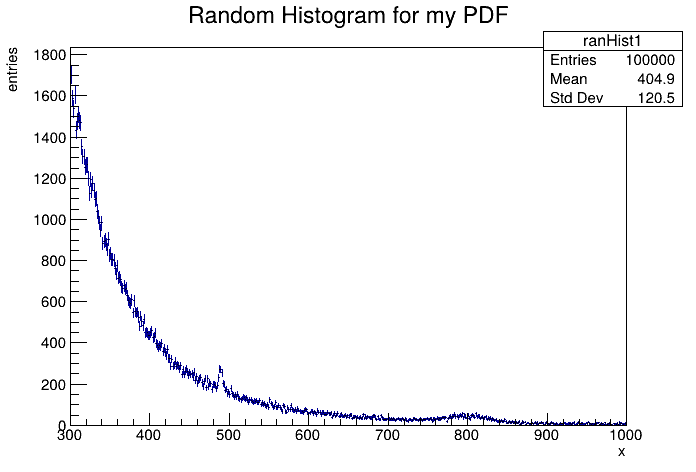

In [ ]:
ranHist1.Draw("e")
tc.Draw()

 Now "pretend" that we don't know the paramaters used to generate the data.

 All fits begin with initial guesses at the best parameter values

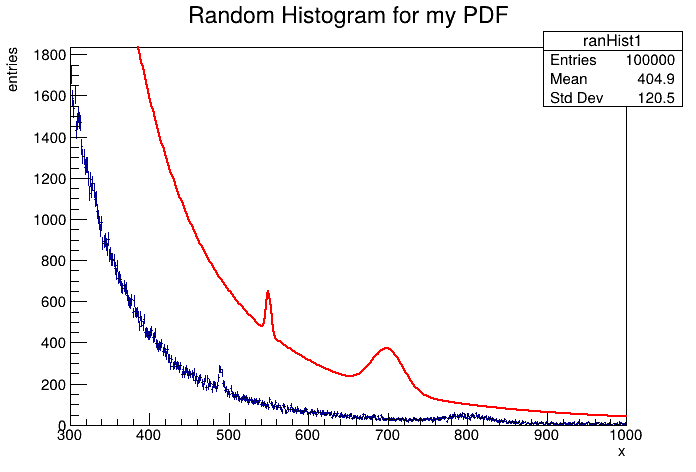

In [ ]:
f1.SetParameters(1e6,4,80,200,550,3,200,700,20)
ranHist1.Draw("e")
f1.Draw("same")
tc.Draw()

To get better qualitative agreement try:

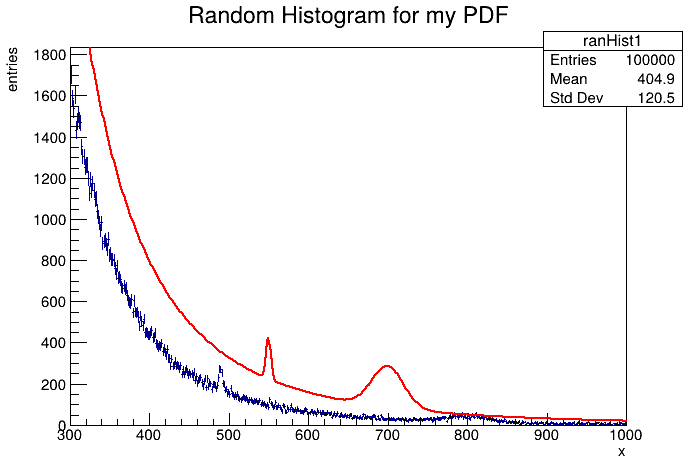

In [ ]:
f1.SetParameters(0.5e6,4,80,200,550,3,200,700,20)
ranHist1.Draw("e")
f1.Draw("same")
tc.Draw()

Try to fit the function to the data:

In [ ]:
result=ranHist1.Fit(f1,"E")
f1=ranHist1.GetFunction("f1")

****************************************
         Invalid FitResult  (status = 2 )
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      1181.69
NDf                       =          491
Edm                       =  3.06436e-07
NCalls                    =         1931
BkgScale                  =       605910   +/-   0           
alpha                     =      4.60207   +/-   0           
beta                      =      83.6329   +/-   0           
A1                        =      201.214   +/-   0           
mu1                       =      552.824   +/-   0           
sig1                      =  -0.00894786   +/-   0           
A2                        =     -6.77557   +/-   0           
mu2                       =      599.954   +/-   0           
sig2                      =     -62.4899   +/-   0           


Warning in <Fit>: Abnormal termination of minimization.


Notice that there is a problem here. <br>
Look at the result:

chi^2: 1181.6921962460247, nDOF: 491, p-value: 8.181133575456766e-59


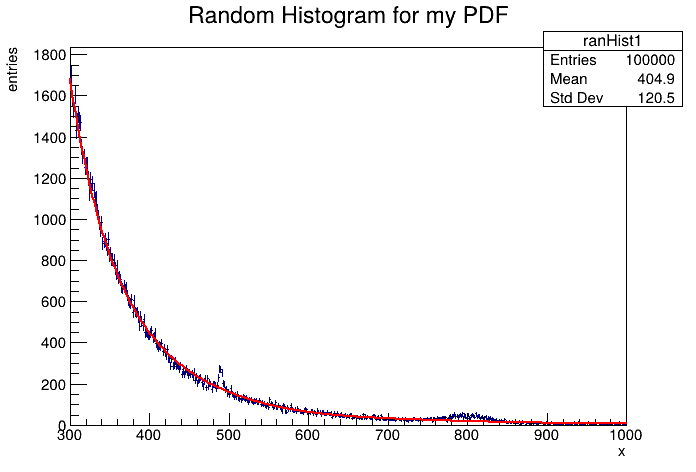

In [ ]:
print(f'chi^2: {f1.GetChisquare()}, nDOF: {f1.GetNDF()}, p-value: {f1.GetProb()}')
ranHist1.Draw("e")
f1.Draw("same")
tc.Draw()

Did the fit work? Did it find both peaks? Probably not. In general, you can't count on complex fits to converge without carefully adjusting the starting parameters. Sure, in this example, you could peek at the parameters used to generate the data, but that's not an option in the real world. Go through the process of adjusting the parameters and replotting the function to get a better representation of the data. Then try a fit and see if you can extract the parameters describing the peeks.

In [ ]:
# extract the parameters and their (parabolic) errors
popt = []
perr = []
for i in range(f1.GetNpar()):
    popt.append(f1.GetParameter(i))
    perr.append(f1.GetParError(i))
    print(f'f1.GetParName(i): {popt[i]:10.2f} +- {perr[i]:10.2f}')

f1.GetParName(i):  605910.14 +-       0.00
f1.GetParName(i):       4.60 +-       0.00
f1.GetParName(i):      83.63 +-       0.00
f1.GetParName(i):     201.21 +-       0.00
f1.GetParName(i):     552.82 +-       0.00
f1.GetParName(i):      -0.01 +-       0.00
f1.GetParName(i):      -6.78 +-       0.00
f1.GetParName(i):     599.95 +-       0.00
f1.GetParName(i):     -62.49 +-       0.00


For you to try
===
In the file datadist.root you will find a histogram representing data from an unknown distribution.

* Develop your own fitting function/model and see how well you can fit this distribution.
* You may need to try a variety of functions.
* Include a plot of your best fit at the bottom of this notebook.
* Include your p-value for the best fit and describe how you settled on this fit versus others.
* Show your best fit parameters and their errors
* Plot the fit residuals, eg for each bin plot (fit-data)/data_uncertianty.  For a good fit the points should randomy fluctuate around 0 (eg no large, contiguous regions above or below 0)
* Plot the pull distribution (for a good fit this should be consisten with a normal distribution w/ $\mu=0,\sigma=1$

For this notebook it is assumed that you'll work with ROOT.

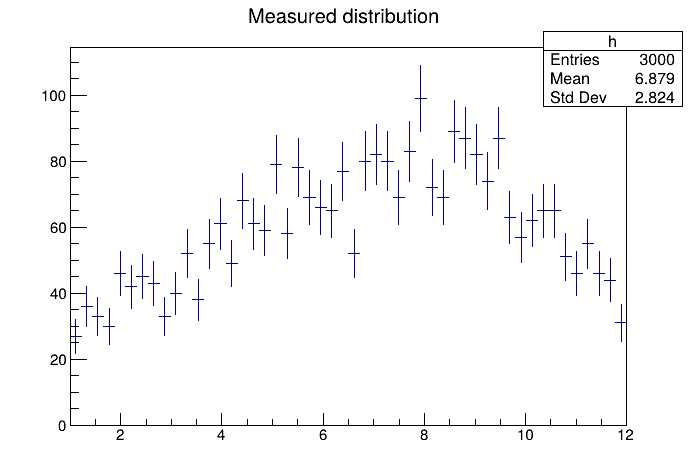

In [6]:
tf=r.TFile("datadist.root")
hist=tf.Get("h")
tc=r.TCanvas()
hist.Draw()
tc.Draw()

**Answers to the above questions**

The final p-value for my fit was roughly 0.144, and I used the reduced chi^2 and the p-value to decide that this was my "best" fit. I attempted three different fits, one quadratic, one quartic, and an additional quartic with variation between the two "delta" parameters. After seeing that the reduced chi^2 and p-value combination of the quartic was significantly better than the quadratic, and that it was identical to the quartic with varied deltas, it made sense to chose the quartic as opposed to the others. If you'd like to see the others scroll to the "attempted fits" section below.

Also, for reference, the "guessed parameters" were guessed with help by chatGPT

p-value: 0.14446105119279892
p:      -0.01 +-       0.00
q:       1.34 +-       0.09
r:      32.17 +-       1.92
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      57.2939
NDf                       =           47
Edm                       =  3.01652e-17
NCalls                    =           58
p                         =   -0.0095626   +/-   0.000656586   -0.000656586 +0.000656586  (Minos) 
q                         =      1.33639   +/-   0.0879073     -0.0879073   +0.0879073    (Minos) 
r                         =       32.173   +/-   1.92071       -1.92071     +1.92071      (Minos) 


Warning in <TFile::Append>: Replacing existing TH1: residuals for fit (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: pulls (Potential memory leak).


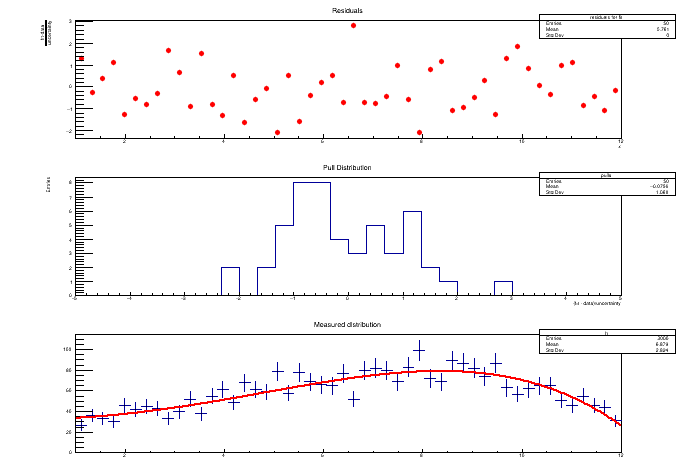

In [34]:
import math
def myfunction(vx, par):
    x = vx[0]
    p,q,r,d = par[0],par[1],par[2],par[3]
    return p*(x-d)**4+q*(x-d)**2+r
xrange=(0,12)
f1 = r.TF1("f1",myfunction,xrange[0],xrange[1],3)  # xrange 300<=x<=1000, there are 9 parameters in this function
f1.SetNpx(500)  # use large number of points in drawing function to resolve small details better
f1.SetParameters(-0.15,-1,90,7)  # define the parameters
f1.SetParNames("p","q","r","d")  # optional, but nice

result=hist.Fit(f1,"E")
f1=hist.GetFunction("f1")
print(f'p-value: {f1.GetProb()}')
popt = []
perr = []
for i in range(f1.GetNpar()):
    popt.append(f1.GetParameter(i))
    perr.append(f1.GetParError(i))
    print(f'{f1.GetParName(i)}: {popt[i]:10.2f} +- {perr[i]:10.2f}')

#ChatGPT aided with residual and pull function.
nbins = hist.GetNbinsX()
xmin  = hist.GetXaxis().GetXmin()
xmax  = hist.GetXaxis().GetXmax()
residuals = r.TH1F("residuals for fit",
                   "Residuals; x; (fit - data) / uncertainty",
                   nbins, xmin, xmax)
for i in range(1, hist.GetNbinsX() + 1):
    x = hist.GetBinCenter(i)
    data = hist.GetBinContent(i)
    fit = f1.Eval(x)
    err = hist.GetBinError(i)
    if err <= 0:
        err = math.sqrt(data) if data > 0 else 1  # fallback for 0 bins
    res = (fit - data) / err
    residuals.SetBinContent(i, res)

pulls = r.TH1F("pulls", "Pull Distribution; (fit - data)/uncertainty; Entries", 30, -5, 5)
for i in range(1, residuals.GetNbinsX() + 1):
    pulls.Fill(residuals.GetBinContent(i))

tc=r.TCanvas()
tc.Divide(1,3)
tc.cd(1)
residuals.SetTitle("Residuals; x; #frac{fit-data}{uncertainty}")
residuals.SetMarkerStyle(20)
residuals.SetMarkerSize(0.5)
residuals.SetMarkerColor(r.kRed)
residuals.SetLineColor(r.kRed)
residuals.Draw("P")
tc.cd(2)
pulls.Draw()
tc.cd(3)
hist.Draw("e")
f1.Draw("same")
tc.Draw()

-----ATTEMPTED FITS-----

p-value: 0.0044179610096474935
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      76.2689
NDf                       =           47
Edm                       =  4.65598e-17
NCalls                    =           57
a                         =      1.37681   +/-   0.108595      -0.108595    +0.108595     (Minos) 
b                         =      19.8425   +/-   1.42778       -1.42778     +1.42778      (Minos) 
c                         =      1.54564   +/-   3.76205       -3.76205     +3.76205      (Minos) 


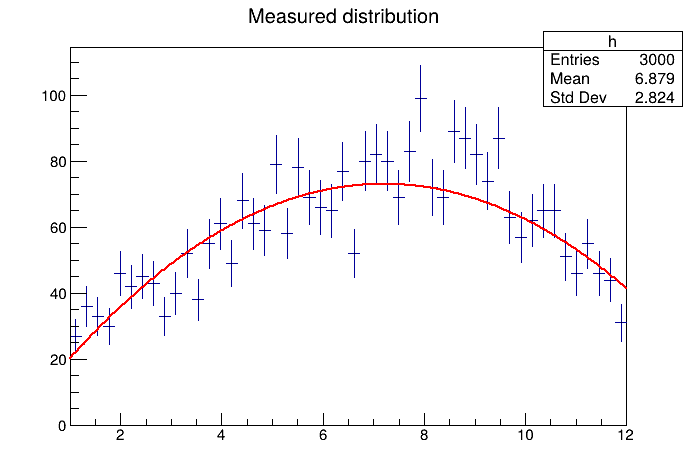

In [12]:
# your work here

def myfunction(vx, par):
    x = vx[0]
    a = par[0]
    b = par[1]
    c = par[2]
    return (-(a*x**2)+(b*x)+c)
xrange=(0,12)
f1 = r.TF1("f1",myfunction,xrange[0],xrange[1],3)  # xrange 300<=x<=1000, there are 9 parameters in this function
f1.SetNpx(500)  # use large number of points in drawing function to resolve small details better
f1.SetParameters(2,20,30)  # define the parameters
f1.SetParNames("a","b","c")  # optional, but nice

result=hist.Fit(f1,"E")
f1=hist.GetFunction("f1")
print(f'p-value: {f1.GetProb()}')

hist.Draw("e")
f1.Draw("same")
tc.Draw()

p-value: 0.14446105119279892
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      57.2939
NDf                       =           47
Edm                       =  3.01652e-17
NCalls                    =           58
p                         =   -0.0095626   +/-   0.000656586   -0.000656586 +0.000656586  (Minos) 
q                         =      1.33639   +/-   0.0879073     -0.0879073   +0.0879073    (Minos) 
r                         =       32.173   +/-   1.92071       -1.92071     +1.92071      (Minos) 


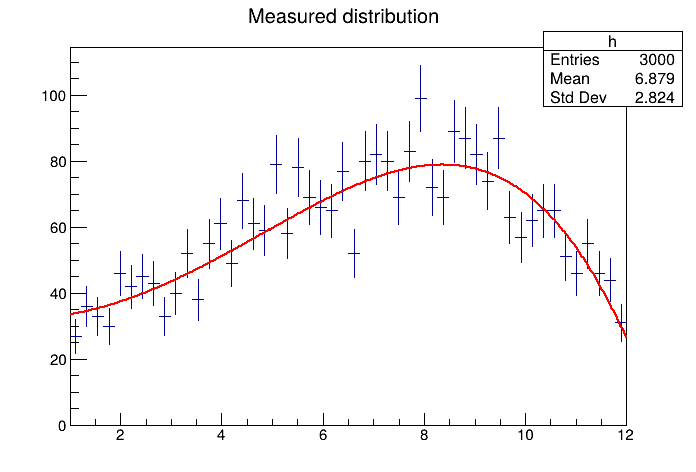

In [14]:
def myfunction(vx, par):
    x = vx[0]
    p,q,r,d = par[0],par[1],par[2],par[3]
    return p*(x-d)**4+q*(x-d)**2+r
xrange=(0,12)
f1 = r.TF1("f1",myfunction,xrange[0],xrange[1],3)  # xrange 300<=x<=1000, there are 9 parameters in this function
f1.SetNpx(500)  # use large number of points in drawing function to resolve small details better
f1.SetParameters(-0.15,-1,90,7)  # define the parameters
f1.SetParNames("p","q","r","d")  # optional, but nice

result=hist.Fit(f1,"E")
f1=hist.GetFunction("f1")
print(f'p-value: {f1.GetProb()}')

hist.Draw("e")
f1.Draw("same")
tc.Draw()

p-value: 0.14446105119279892
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      57.2939
NDf                       =           47
Edm                       =  3.01652e-17
NCalls                    =           58
p                         =   -0.0095626   +/-   0.000656586   -0.000656586 +0.000656586  (Minos) 
q                         =      1.33639   +/-   0.0879073     -0.0879073   +0.0879073    (Minos) 
r                         =       32.173   +/-   1.92071       -1.92071     +1.92071      (Minos) 


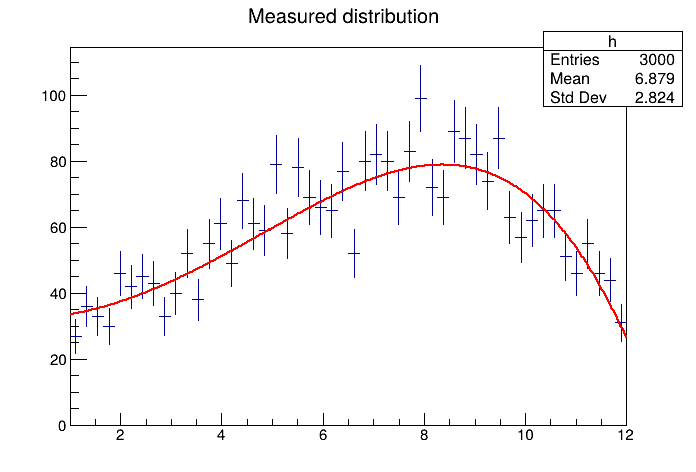

In [15]:
def myfunction(vx, par):
    x = vx[0]
    p,q,r,d,e = par[0],par[1],par[2],par[3],par[4]
    return p*(x-d)**4+q*(x-e)**2+r
xrange=(0,12)
f1 = r.TF1("f1",myfunction,xrange[0],xrange[1],3)  # xrange 300<=x<=1000, there are 9 parameters in this function
f1.SetNpx(500)  # use large number of points in drawing function to resolve small details better
f1.SetParameters(-0.15,-1,90,7,6.8)  # define the parameters
f1.SetParNames("p","q","r","d")  # optional, but nice

result=hist.Fit(f1,"E")
f1=hist.GetFunction("f1")
print(f'p-value: {f1.GetProb()}')

hist.Draw("e")
f1.Draw("same")
tc.Draw()